In [ ]:
##########################################################
# DSC5103 Statistics
# Session 9. Trees I
# 2016.12
#
# run decision tree using the tree() and cv.tree() function in the "tree" package
# demo for Regression trees
# using the Hitters dataset in package "ISLR"
##########################################################

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error

%matplotlib inline

In [2]:
## remove na values
df = pd.read_csv('Heart.csv').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 15 columns):
Unnamed: 0    297 non-null int64
Age           297 non-null int64
Sex           297 non-null int64
ChestPain     297 non-null object
RestBP        297 non-null int64
Chol          297 non-null int64
Fbs           297 non-null int64
RestECG       297 non-null int64
MaxHR         297 non-null int64
ExAng         297 non-null int64
Oldpeak       297 non-null float64
Slope         297 non-null int64
Ca            297 non-null float64
Thal          297 non-null object
AHD           297 non-null object
dtypes: float64(2), int64(10), object(3)
memory usage: 37.1+ KB


In [3]:
df.head()

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df.ChestPain = pd.factorize(df.ChestPain)[0]
df.Thal = pd.factorize(df.Thal)[0]
df.AHD = df.AHD.map({'No':0, 'Yes':1})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
Age          297 non-null int64
Sex          297 non-null int64
ChestPain    297 non-null int64
RestBP       297 non-null int64
Chol         297 non-null int64
Fbs          297 non-null int64
RestECG      297 non-null int64
MaxHR        297 non-null int64
ExAng        297 non-null int64
Oldpeak      297 non-null float64
Slope        297 non-null int64
Ca           297 non-null float64
Thal         297 non-null int64
AHD          297 non-null int64
dtypes: float64(2), int64(12)
memory usage: 34.8 KB


In [6]:
# split training and test data 50/50
X = df.drop('AHD', axis=1)
y = df.AHD
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

In [7]:
## grow a tree
# Pruning not supported. Choosing max depth 3)
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.84459459459459463

In [8]:
clfclass = np.asarray(clf.classes_, dtype=str)

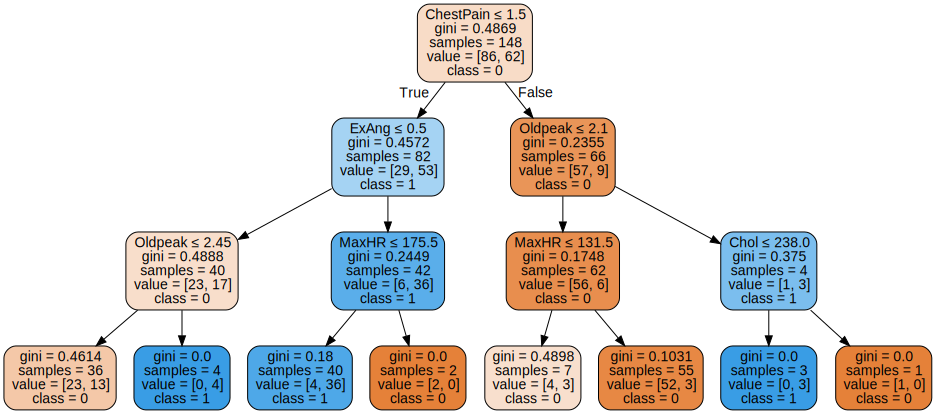

In [9]:
export_graphviz(clf, out_file="mytree.dot", feature_names=X_train.columns, class_names=clfclass, 
                filled=True, rounded=True, special_characters=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [10]:
pred = clf.predict(X_test)
predprob = clf.predict_proba(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
print(cm)

     No  Yes
No   65   36
Yes   9   39


In [11]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds=roc_curve(y_test, predprob[:,1])

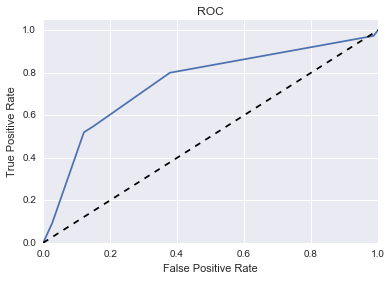

In [12]:
ax=plt.gca()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC')

In [13]:
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.751891891892
